**Import Necessary Libraries**

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, recall_score, precision_score, accuracy_score

import lime
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer

**Load and Read Train Data**

In [2]:
path = "C:/Users/shakib/Downloads/Train Data.csv"
train_data = pd.read_csv(path)

**1. Extract Label and Features** <br>
**2. Convert to Numpy Array**

In [3]:
X = train_data.drop(columns=['Label'])
y = train_data['Label']

X = np.asarray(X)
y = np.asarray(y)

**Define K-Fold Cross-Validation**

In [4]:
kfold = KFold(n_splits=5, shuffle=True, random_state=4)

**Initialize Base and Meta Models**

In [5]:
DT = DecisionTreeClassifier()
SVM = SVC(probability=True)

class FNN(nn.Module):
    def __init__(self, input_dim):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x

meta_model = LogisticRegression(C=0.01, solver='liblinear')

**Define Hyperparameter Grids for GridSearchCV**

In [6]:
dt_param_grid = {
    'max_depth': [None, 4, 5, 6],
    'min_samples_split': [2, 5, 10]
}

svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

**Train and Predict**

In [7]:
# Track and extract base model performances and features
meta_features = []
true_labels = []
SVM_scores = []
FNN_scores = []
DT_scores = []

# K-fold cross-validation loop
for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train and get predictions from Decision Tree with GridSearchCV
    dt_grid_search = GridSearchCV(estimator=DT, param_grid=dt_param_grid, scoring='roc_auc', cv=5, verbose=0, n_jobs=-1)
    dt_grid_search.fit(X_train, y_train)
    decision_tree_pred = dt_grid_search.predict_proba(X_test)[:, 1]
    dt_roc_auc = roc_auc_score(y_test, decision_tree_pred)
    DT_scores.append(dt_roc_auc)

    # Train and get predictions from SVM with GridSearchCV
    svm_grid_search = GridSearchCV(estimator=SVM, param_grid=svm_param_grid, scoring='roc_auc', cv=5, verbose=0, n_jobs=-1)
    svm_grid_search.fit(X_train, y_train)
    svm_pred = svm_grid_search.predict_proba(X_test)[:, 1]
    svm_roc_auc = roc_auc_score(y_test, svm_pred)
    SVM_scores.append(svm_roc_auc)

    # Train and get predictions from Feedforward Neural Network with early stopping
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

    fnn = FNN(input_dim=X.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(fnn.parameters(), lr=0.01)

    # Early stopping parameters
    early_stop_patience = 10
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None  # Variable to store the best model state

    for epoch in range(60):
        # Training phase
        fnn.train()
        optimizer.zero_grad()
        outputs = fnn(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        # Calculate validation loss
        fnn.eval()
        with torch.no_grad():
            val_outputs = fnn(X_test_tensor)
            val_loss = criterion(val_outputs, torch.tensor(y_test, dtype=torch.float32).view(-1, 1))

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset counter if validation loss improves
            best_model_state = fnn.state_dict()  # Save the model state if it improves
        else:
            patience_counter += 1  # Increment counter if no improvement

        if patience_counter >= early_stop_patience:
            fnn.load_state_dict(best_model_state)  # Load the best model if early stopped
            break

    # Make predictions with the trained Feedforward Neural Network model
    fnn.eval()
    with torch.no_grad():
        nn_pred = fnn(X_test_tensor).numpy().flatten()
    nn_roc_auc = roc_auc_score(y_test, nn_pred)
    FNN_scores.append(nn_roc_auc)

    # Aggregate predictions for meta model
    meta_features.append(np.column_stack((decision_tree_pred, svm_pred, nn_pred)))
    true_labels.append(y_test)

**Concatenate Meta Features and True Labels**

In [8]:
meta_features = np.vstack(meta_features)
true_labels = np.concatenate(true_labels)

**Train Meta Model on Meta Features**

In [9]:
meta_model.fit(meta_features, true_labels)

LogisticRegression(C=0.01, solver='liblinear')

**Get Predictions from Meta Model**

In [10]:
meta_predictions = meta_model.predict(meta_features)

**Convert Probabilities to Binary Predictions**

In [11]:
meta_labels = (meta_predictions >= 0.5).astype(int)

**Define Confusion Matrix**

In [12]:
def plot_confusion_matrix(cm, classes, normalize=False, title=' ', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

**Evaluate Ensemble Model**

In [13]:
roc_auc = roc_auc_score(true_labels, meta_predictions)
conf_matrix = confusion_matrix(true_labels, meta_labels)
f1 = f1_score(true_labels, meta_labels)
recall = recall_score(true_labels, meta_labels)
precision = precision_score(true_labels, meta_labels)
accuracy = accuracy_score(true_labels, meta_labels)

**Load and Read Unseen Data**

In [14]:
path2 = "C:/Users/shakib/Downloads/Unseen Data.csv"
unseen_data = pd.read_csv(path2)

**Extract Label and Features from Unseen Data**

In [15]:
X_unseen = unseen_data.drop(columns=['Label']).values 
true_labels_unseen = unseen_data['Label'].values

# For Neural Network
X_unseen_tensor = torch.tensor(X_unseen, dtype=torch.float32)

**Generate Predictions from Trained Base Models on Unseen Data**

In [16]:
decision_tree_pred_unseen = dt_grid_search.predict_proba(X_unseen)[:, 1]
svm_pred_unseen = svm_grid_search.predict_proba(X_unseen)[:, 1]

fnn.eval()
with torch.no_grad():
    nn_pred_unseen = fnn(X_unseen_tensor).numpy().flatten()

**Aggregate Predictions for Meta Features**

In [17]:
meta_features_unseen = np.column_stack((decision_tree_pred_unseen, svm_pred_unseen, nn_pred_unseen))

**Get Predictions from Meta Models for Unseen Data**

In [18]:
meta_predictions_unseen = meta_model.predict(meta_features_unseen)

**Convert Probabilities to Binary Predictions**

In [19]:
meta_labels_unseen = (meta_predictions_unseen >= 0.5).astype(int)

**Evaluate Ensemble Model for Unseen Data**

In [20]:
roc_auc_unseen = roc_auc_score(true_labels_unseen, meta_predictions_unseen)
conf_matrix_unseen = confusion_matrix(true_labels_unseen, meta_labels_unseen)
f1_unseen = f1_score(true_labels_unseen, meta_labels_unseen)
recall_unseen = recall_score(true_labels_unseen, meta_labels_unseen)
precision_unseen = precision_score(true_labels_unseen, meta_labels_unseen)
accuracy_unseen = accuracy_score(true_labels_unseen, meta_labels_unseen)

**Results Table**

In [21]:
data = {
    'Evaluation Metrics': [
        'ROC-AUC Score', 
        'F1 Score', 
        'Recall',
        'Precision',
        'Accuracy'
    ],
    'Train Data': [
        f"{roc_auc * 100:.2f}%", 
        f"{f1 * 100:.2f}%", 
        f"{recall * 100:.2f}%",
        f"{precision * 100:.2f}%",
        f"{accuracy * 100:.2f}%"
    ],
    'Unseen Data': [
        f"{roc_auc_unseen * 100:.2f}%", 
        f"{f1_unseen * 100:.2f}%", 
        f"{recall_unseen * 100:.2f}%",
        f"{precision_unseen * 100:.2f}%",
        f"{accuracy_unseen * 100:.2f}%"
    ]
}

df = pd.DataFrame(data)
df

,Evaluation Metrics,Train Data,Unseen Data
0,ROC-AUC Score,92.74%,92.24%
1,F1 Score,93.12%,92.20%
2,Recall,95.30%,95.59%
3,Precision,91.03%,89.04%
4,Accuracy,92.80%,92.14%


**Confusion Matrix**

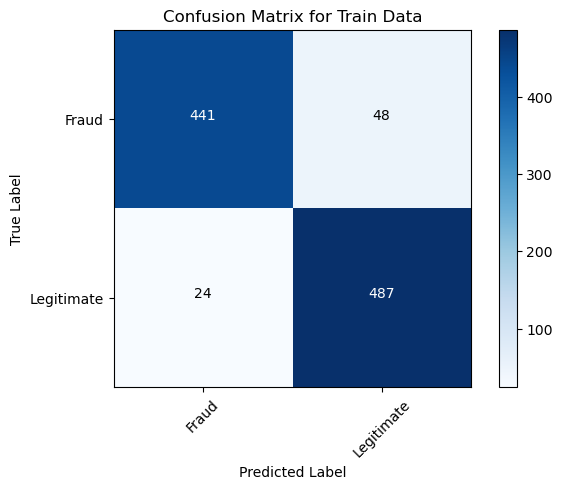

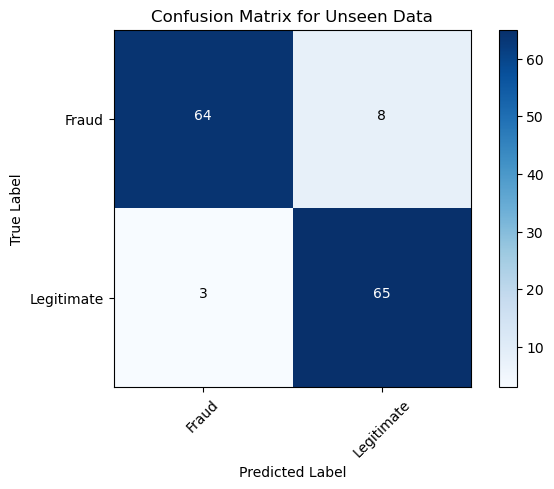

In [22]:
plt.figure()
plot_confusion_matrix(conf_matrix, classes=['Fraud','Legitimate'], normalize= False, title='Confusion Matrix for Train Data')

plt.figure()
plot_confusion_matrix(conf_matrix_unseen, classes=['Fraud','Legitimate'], normalize= False, title='Confusion Matrix for Unseen Data')

**Probability Predictions from Feedforward Neural Network**

In [23]:
def fnn_predict_proba(X):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    with torch.no_grad():
        probs = fnn(X_tensor).numpy()
        return np.column_stack([1 - probs, probs])

**Generate LIME Explainers for Each Base Model**

In [24]:
import lime
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer

feature_names = unseen_data.drop(columns=['Label']).columns.tolist()
explainer_dt = LimeTabularExplainer(X_train, feature_names=feature_names, 
                                    class_names=['Legitimate', 'Fraud'], mode='classification')
explainer_svm = LimeTabularExplainer(X_train, feature_names=feature_names, 
                                     class_names=['Legitimate', 'Fraud'], mode='classification')
explainer_nn = LimeTabularExplainer(X_train, feature_names=feature_names, 
                                    class_names=['Legitimate', 'Fraud'], mode='classification')

**Generate Simplified Customer-Readable Explanation**

In [25]:
def generate_customer_readable_explanation(attributes_dt, attributes_svm, attributes_nn):
    review_issues = any("reviews" in attr for attr in (attributes_dt + attributes_svm + attributes_nn))
    contact_issues = any("free contact emails" in attr for attr in (attributes_dt + attributes_svm + attributes_nn))
    payment_issues = any("payment" in attr for attr in (attributes_dt + attributes_svm + attributes_nn))
    domain_issues = any("domain" in attr for attr in (attributes_dt + attributes_svm + attributes_nn))
    ssl_issues = any("SSL certificate" in attr for attr in (attributes_dt + attributes_svm + attributes_nn))

    explanation = "Key factors include "
    explanation += "a lack of verified customer reviews, " if review_issues else ""
    explanation += "absence of reliable contact information, " if contact_issues else ""
    explanation += "missing or uncommon payment options, " if payment_issues else ""
    explanation += "indicators of a recently registered or suspicious domain, " if domain_issues else ""
    explanation += "and SSL certificate issues, " if ssl_issues else ""
    
    explanation = explanation.strip(", ") + "."
    return explanation

**Refined Output for Flagged Fraud Instances**

In [26]:
results = []

for i in range(len(X_unseen)):
    if meta_labels_unseen[i] == 1:  # Check if flagged as fraud
        instance = X_unseen[i]

        # Generate LIME explanations for each model
        exp_dt = explainer_dt.explain_instance(instance, dt_grid_search.predict_proba)
        attributes_dt = [feature for feature, weight in exp_dt.as_list() if weight > 0]

        exp_svm = explainer_svm.explain_instance(instance, svm_grid_search.predict_proba)
        attributes_svm = [feature for feature, weight in exp_svm.as_list() if weight > 0]

        exp_nn = explainer_nn.explain_instance(instance, fnn_predict_proba)  # Use the new function
        attributes_nn = [feature for feature, weight in exp_nn.as_list() if weight > 0]

        # Generate a simplified explanation
        explanation = generate_customer_readable_explanation(attributes_dt, attributes_svm, attributes_nn)

        # Append the result to the list
        results.append({
            "Instance": i + 1,
            "Simplified Explanation": explanation
        })

results_df = pd.DataFrame(results)
pd.set_option('display.max_colwidth', None)
results_df.head(5)

,Instance,Simplified Explanation
0,1,"Key factors include a lack of verified customer reviews, missing or uncommon payment options, indicators of a recently registered or suspicious domain."
1,7,"Key factors include a lack of verified customer reviews, absence of reliable contact information, missing or uncommon payment options, indicators of a recently registered or suspicious domain, and SSL certificate issues."
2,10,"Key factors include a lack of verified customer reviews, absence of reliable contact information, missing or uncommon payment options, indicators of a recently registered or suspicious domain."
3,11,"Key factors include a lack of verified customer reviews, absence of reliable contact information, missing or uncommon payment options, indicators of a recently registered or suspicious domain, and SSL certificate issues."
4,12,"Key factors include a lack of verified customer reviews, absence of reliable contact information, missing or uncommon payment options, indicators of a recently registered or suspicious domain, and SSL certificate issues."
